In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
import data_processing 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence

from sklearn.inspection import PartialDependenceDisplay
import shap
from sklearn.inspection import permutation_importance

## 1. Find most important Features:



### 1.1 pick most correlating to target feature:


Index(['Absolute Magnitude', 'Orbit Uncertainity',
       'Minimum Orbit Intersection', 'Perihelion Distance'],
      dtype='object')


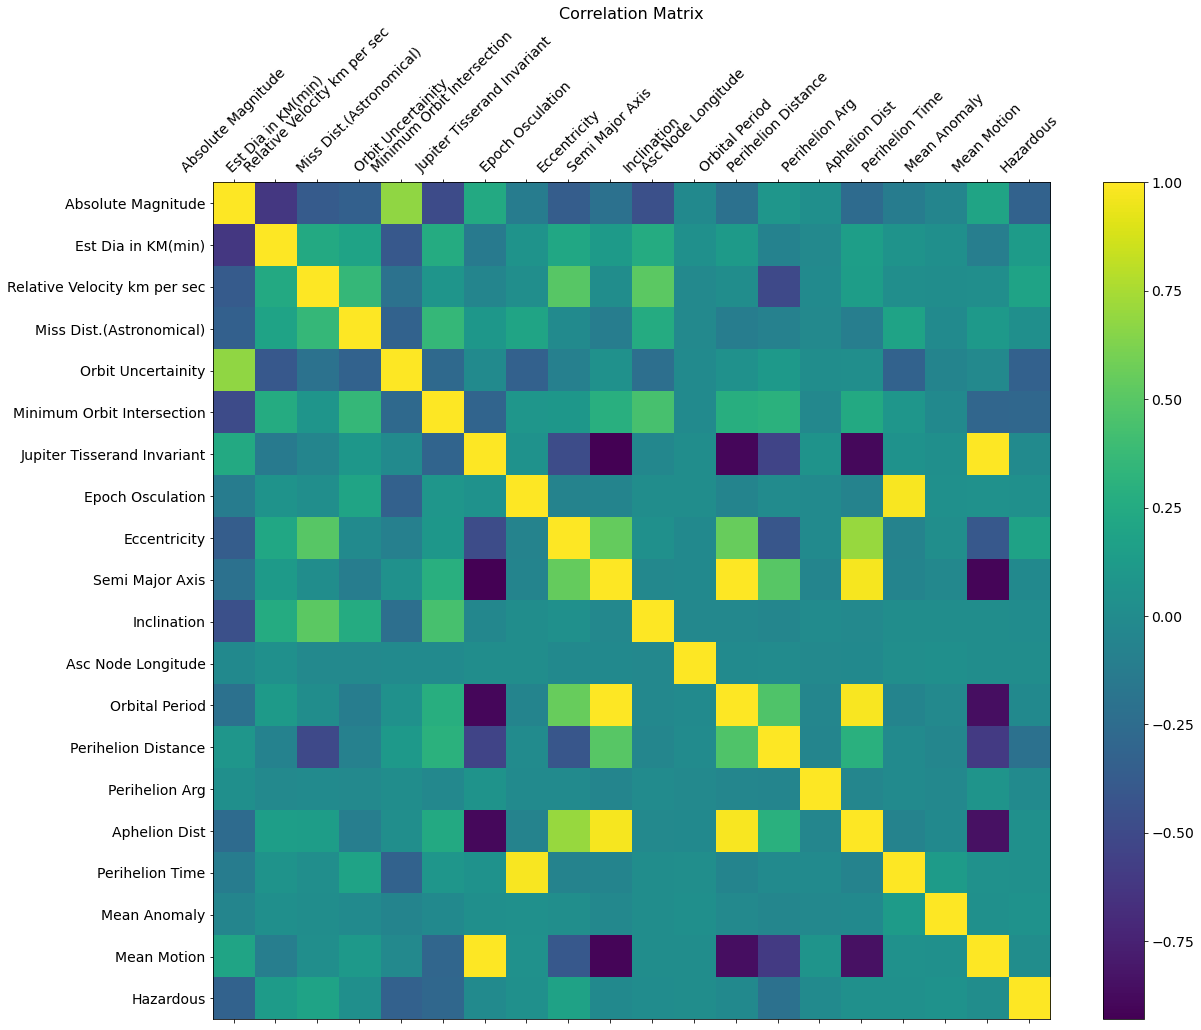

In [36]:
X, y = data_processing.load_nasa()
df = pd.concat([X, y], axis=1)
cor = df.corr()
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
cor_target = abs(cor["Hazardous"])
relevant_features = cor_target[cor_target>0.2]
relevant_features.drop(labels=["Hazardous"], inplace=True)
print(relevant_features.index)
plt.savefig("res/plots/correlation_matrix.png")
X_corr_most = X[relevant_features.index]
#X_corr_most.drop(column=["Hazardous"], inplace=True)

### 1.2 pick by decision tree importance

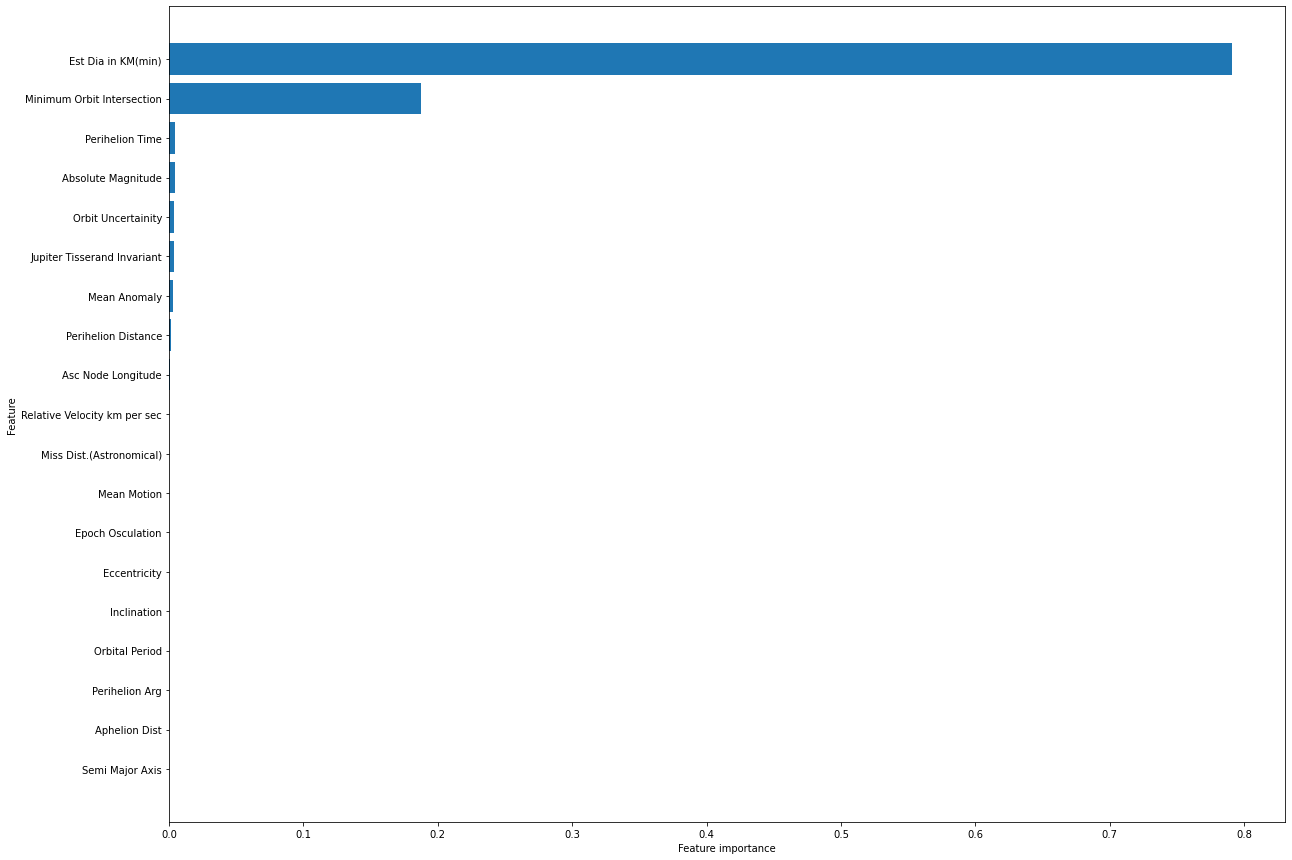

In [37]:
# DECISION TREE
# show most important:

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X, y)
feature_importance = dt.feature_importances_ 
sorted_idx = np.argsort(feature_importance) # Sort index on feature importance
fig = plt.figure(figsize=(20, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])

plt.xlabel("Feature importance") # Add x axis
plt.ylabel("Feature") # Add y axis
plt.savefig("res/plots/dt_feature_importance.png")

In [38]:
# pick k most important features
k = 2
X_most_dt = X[X.columns[np.flip(sorted_idx)][0:k]]
X_most_dt 

,Est Dia in KM(min),Minimum Orbit Intersection
0,0.127220,0.025282
1,0.146068,0.186935
2,0.231502,0.043058
3,0.008801,0.005512
4,0.127220,0.034798
...,...,...
4682,0.044112,0.019777
4683,0.006089,0.006451
4684,0.076658,0.059972
4685,0.116026,0.177510


### 1.3 pick by DT or most corr

In [39]:
X = X_corr_most  #X_corr_most (by correlation) or X_most_dt (by decision tree)

# ONLY PART TO CHANGE FOR CHANGING DESTRIBUTION



## 2. Add feature with normal distribution

In [40]:
X["random"] = np.random.normal(size=X.shape[0])

import os
plot_folder = "res/plots/normal"
if (not os.path.exists(plot_folder)):
    os.mkdir(plot_folder)



## 3. Models:


## 3.0 preprocess the data


In [41]:
# split into test and train:

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Get mean and standard deviation from train data
X_means = x_train.mean()
#X_means['intercept'] = 0
X_std = x_train.std()
#X_std['intercept'] = 1

# Normalize train and test data (Centering, unit variance)
x_train = x_train.apply(lambda x: (x-X_means)/X_std, axis = 1)
x_test = x_test.apply(lambda x: (x-X_means)/X_std, axis = 1)

### 3.1 Neural Network: 
It depends which neural network we decide to use. I decided for an MLPRegressor
Use the training data to find the best hyperparameters for the MLP using GridSearchCV. Then train the model and predict using the 'best' model with the best parameters. 


In [42]:

from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import numpy as np

mlp = MLPClassifier()

#Hyperparameters that we consider:
param_grid = {
    'learning_rate_init': [0.001, 0.01, 0.1, 0.2],
    'alpha': [0.0001, 0.001, 0.05, 0.1],
    'activation': ['relu'],
    'hidden_layer_sizes': [(20,), (50,), (100,)],
    'solver': ['adam', 'sgd' ]
}
best_param_grid = {
    'learning_rate_init': [0.01],
    'alpha': [0.0001],
    'activation': ['relu'],
    'hidden_layer_sizes': [(100,)],
    'solver': [ 'adam' ]
}


grid_search = GridSearchCV(mlp, param_grid)
grid_search.fit(x_train, y_train)

nn = grid_search.best_estimator_
nn.fit(x_train, y_train, )

y_pred = nn.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
file = open(f"{plot_folder}/performence.txt", "w")
file.write(f"Neural Network")
file.write(f"Parameters: {grid_search.best_params_}\n")
file.write(f"Accuracy: {accuracy}\n")
file.write(f"RMSE: {rmse}\n")
file.write(f"F1: {f1}\n")
file.close() 

print(f"RMSE: {rmse}")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")

/home/robin/anaconda3/envs/uu_courses/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/home/robin/anaconda3/envs/uu_courses/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/home/robin/anaconda3/envs/uu_courses/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/home/robin/anaconda3/envs/uu_courses/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/home/robin/anaconda3/envs/uu_course

RMSE: 0.10325202569555011
Accuracy: 0.9893390191897654
F1: 0.9664429530201343


In [43]:
### SHAP
explainer = shap.KernelExplainer(nn.predict,x_test)

shap_values = explainer(x_test)

Using 938 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/938 [00:00<?, ?it/s]

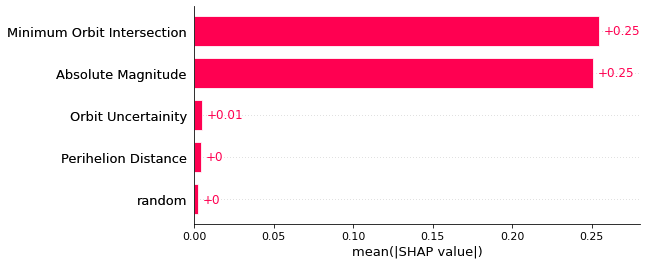

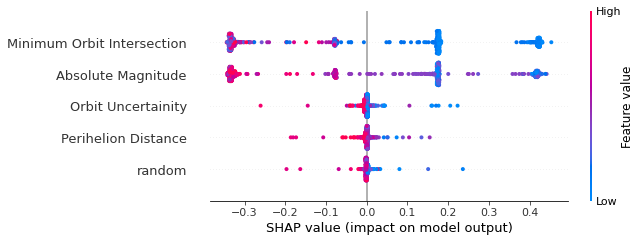

In [44]:

shap.plots.bar(shap_values, show=False)

plt.savefig(f"{plot_folder}/nn_shap_bar.png")
plt.show()
shap.plots.beeswarm(shap_values, show=False)

plt.savefig(f"{plot_folder}/nn_shap_beeswarm.png")
plt.show()

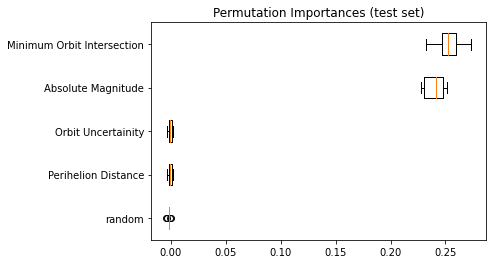

In [45]:
# PFI

pfi = permutation_importance(nn, x_test, y_test, n_repeats=10, random_state=42)
sorted_idx = pfi.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(pfi.importances[sorted_idx].T, vert=False, labels=np.array(X.columns)[sorted_idx])
ax.set_title("Permutation Importances (test set)")
plt.savefig(f"{plot_folder}/nn_pfi.png")



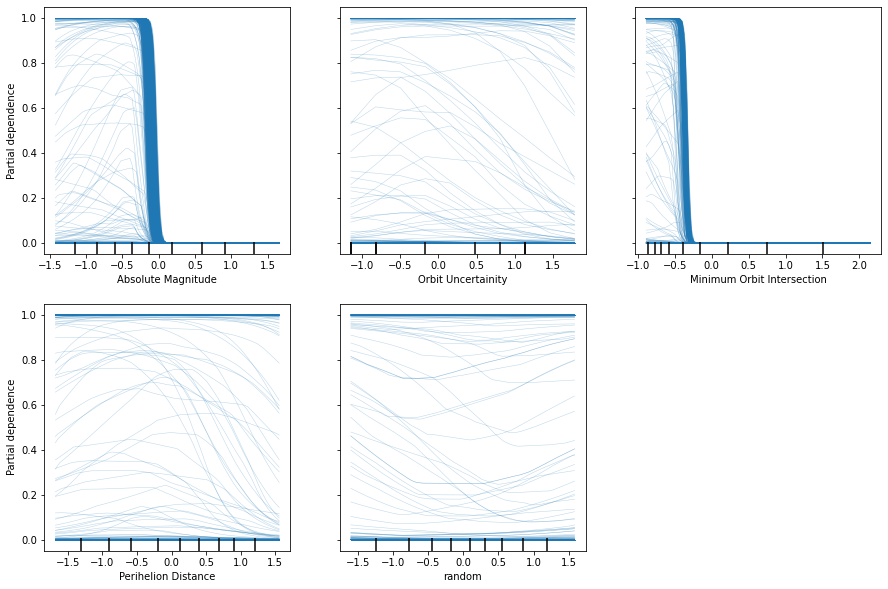

In [46]:
pdd = PartialDependenceDisplay.from_estimator(nn, x_test, x_test.columns,

    kind='individual')
pdd.figure_.set_figwidth(15)
pdd.figure_.set_figheight(10)
plt.savefig(f"{plot_folder}/nn_pdp.png")
plt.show()

### 3.2 EBM (Explainable Boosting Machine)
not part of black box models... just copied from the programming assignment 

In [47]:
from interpret import show, preserve

In [48]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show, preserve

ebm = ExplainableBoostingClassifier().fit(x_train, y_train)
### SHAP
y_pred = ebm.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
y_pred = np.where(y_pred > 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")


file = open(f"{plot_folder}/performence.txt", "w")
file.write(f"EBM")
file.write(f"Parameters: {grid_search.best_params_}\n")
file.write(f"Accuracy: {accuracy}\n")
file.write(f"RMSE: {rmse}\n")
file.write(f"F1: {f1}\n")
file.close() 

RMSE: 0.07301020754057114
Accuracy: 0.9946695095948828
F1: 0.9833887043189369


In [49]:
show(ebm.explain_global())
preserve(ebm.explain_global(), file_name=f"{plot_folder}/ebm.png")

<!-- http://127.0.0.1:7001/139883532083152/ -->

/home/robin/anaconda3/envs/uu_courses/lib/python3.11/site-packages/plotly/offline/offline.py:557: UserWarning:

Your filename `res/plots/normal/ebm.png` didn't end with .html. Adding .html to the end of your file.



gio: file:///home/robin/uu/hcml/HCML_Project/res/plots/normal/ebm.png.html: No application is registered as handling this file


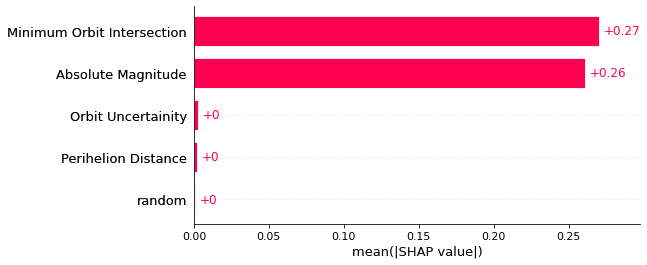

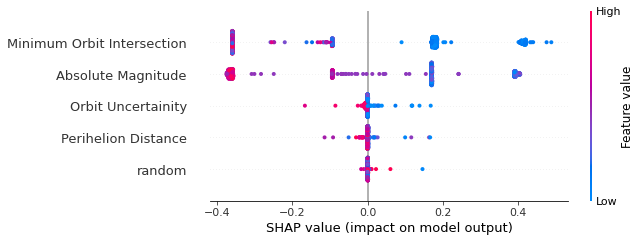

<Figure size 432x288 with 0 Axes>

In [50]:
explainer = shap.Explainer(ebm.predict, x_test)

shap_values = explainer(x_test)
shap.plots.bar(shap_values)
plt.savefig(f"{plot_folder}/ebm_shap_bar.png")
shap.plots.beeswarm(shap_values)
plt.savefig(f"{plot_folder}/ebm_shap_beeswarm.png")

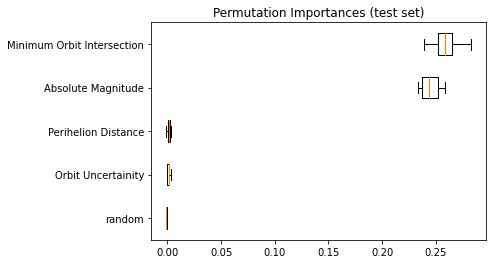

In [51]:
# PFI

pfi = permutation_importance(ebm, x_test, y_test, n_repeats=10, random_state=42)
sorted_idx = pfi.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(pfi.importances[sorted_idx].T, vert=False, labels=np.array(X.columns)[sorted_idx])
ax.set_title("Permutation Importances (test set)")
plt.savefig(f"{plot_folder}/ebm_pfi.png")

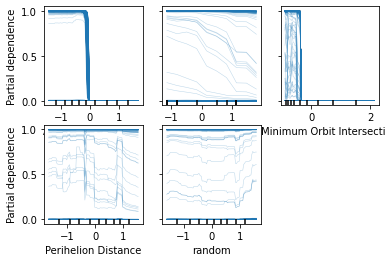

In [52]:
PartialDependenceDisplay.from_estimator(ebm, x_test, x_test.columns,

    kind='individual')
pdd.figure_.set_figwidth(15)
pdd.figure_.set_figheight(10)
plt.savefig(f"{plot_folder}/ebm_pdp.png")
plt.show()